# This notebook demonstrates plotting various MCS track statistics between OBS and Model for land vs. ocean MCSs separately
## Require data: MCS final track statistics files
- mcs_tracks_final_*.nc

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.geoaxes as crs_geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline

## Specify region of interest, months, land/ocean MCS definition

In [2]:
# Select a region (Amazon, Argentina)
region = 'Amazon'
# region = 'Argentina'

# Min number of MCS to plot
min_ntracks = 10

# MCS lifetime limits
lifetime_bounds = [2,60]

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.9
ocean_frac_thresh = 0.1

# Define region bounds
box_arg = [-68,-50,-40,-20]
box_amz = [-70,-35,-20,10]
# Months to include
months_amz = [1,2,3,4,10,11,12]
months_arg = [1,2,3,10,11,12]

# Lookup region based on input
bounds_dict = {'Argentina':box_arg, 'Amazon':box_amz}
months_dict = {'Argentina':months_arg, 'Amazon':months_amz}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

Amazon lat/lon bounds: [-70, -35, -20, 10]
Amazon months: [1, 2, 3, 4, 10, 11, 12]


### Show a map for the subset region

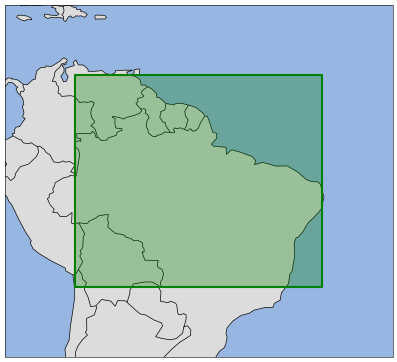

In [3]:
resolution = '110m'
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=180)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
ax.add_feature(borders, edgecolor='k', facecolor='none')
ax.add_feature(states, edgecolor='k', facecolor='none')
# Plot a box region in the inset
box = sgeom.box(minx=bounds[0], maxx=bounds[1], miny=bounds[2], maxy=bounds[3])
ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=3)
ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

## Specify input data location

In [4]:
# Specify years to include in the statistics
years = [2010, 2015, 2018]

# Sepcify directory of the MCS track stats file
rootdir = '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/'
files_obs = []
files_m1 = []
for yy in years:
    files_obs = files_obs + sorted(glob.glob(f'{rootdir}GPM/stats/mcs_tracks_final_{yy}*.nc'))
    files_m1 = files_m1 + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nfiles_obs = len(files_obs)
nfiles_wrf = len(files_m1)
print(f'Number of files (OBS): {nfiles_obs}')
print(f'Number of files (WRF): {nfiles_wrf}')

# Output figure directory
figdir = f'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (OBS): 3
Number of files (WRF): 3
/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/


In [5]:
files_obs

['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/mcs_tracks_final_20100601.0000_20110601.0000.nc',
 '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/mcs_tracks_final_20150601.0000_20160601.0000.nc',
 '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/GPM/stats/mcs_tracks_final_20180601.0000_20190601.0000.nc']

In [6]:
files_m1

['/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/mcs_tracks_final_20100601.0000_20110601.0000.nc',
 '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/mcs_tracks_final_20150601.0000_20160601.0000.nc',
 '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/WRF/stats/mcs_tracks_final_20180601.0000_20190601.0000.nc']

In [7]:
# Read OBS data
dsobs = xr.open_mfdataset(files_obs, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
# dsobs

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/

In [8]:
# Read Model data
dsm1 = xr.open_mfdataset(files_m1, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_wrf = dsm1.dims['tracks']
dsm1['tracks'] = np.arange(0, ntracks_wrf)
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']
# Convert longitudes from 0~360 to -180~+180
dsm1['meanlon'] = ((dsm1.meanlon - 180) % 360) - 180
dsm1['pf_lon'] = ((dsm1.pf_lon - 180) % 360) - 180
dsm1['pf_lon_centroid'] = ((dsm1.pf_lon_centroid - 180) % 360) - 180
dsm1['pf_lon_weightedcentroid'] = ((dsm1.pf_lon_weightedcentroid - 180) % 360) - 180
# dsm1

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/

## Custom functions for track selections

In [9]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    """
    Find tracks within a region, lifetime, and month bounds.
    """
    # Get the track initiation month and location
    start_month = start_basetime.dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

## Subset tracks within a region and months

In [10]:
# Get time resolution of data
time_res_obs = dsobs.attrs['time_resolution_hour']
time_res_m1 = dsm1.attrs['time_resolution_hour']
# Convert track duration to physical lifetime
lifetime_obs = dsobs.track_duration * time_res_obs
lifetime_m1 = dsm1.track_duration * time_res_obs

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, lifetime_obs, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (OBS): {len(mcsidx_obs)}')
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, lifetime_m1, lon_bounds, lat_bounds, lifetime_bounds, months)
print(f'Number of tracks (WRF): {len(mcsidx_m1)}')

Number of tracks (OBS): 5640
Number of tracks (WRF): 4491


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/core/accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


(array([ 676.,  681.,  800.,  632.,    0.,    0.,    0.,    0.,    0.,
         500., 1202.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <BarContainer object of 11 artists>)

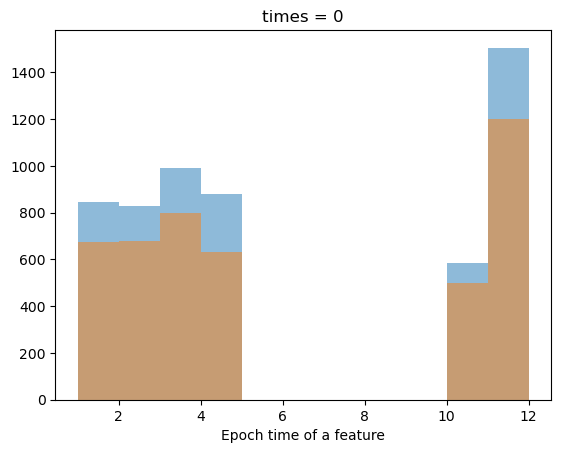

In [11]:
# Check the distribution of tracks by month
dsobs.base_time.dt.month.isel(tracks=mcsidx_obs, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)
dsm1.base_time.dt.month.isel(tracks=mcsidx_m1, times=0).plot.hist(bins=np.arange(1,13,1), alpha=0.5)

## Separate land vs. ocean MCS

In [12]:
# Separate land vs. ocean MCS
ds_l_obs, ds_o_obs = get_land_ocean_ds(dsobs, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}, Number of ocean MCS (OBS): {ds_o_obs.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsm1, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS (WRF): {ds_l_m1.dims['tracks']}, Number of ocean MCS (WRF): {ds_o_m1.dims['tracks']}")

Number of land MCS (OBS): 4690, Number of ocean MCS (OBS): 450
Number of land MCS (WRF): 3965, Number of ocean MCS (WRF): 230


## Find merge/split track indices

In [13]:
tid_o_obs = find_merge_split_tracks(ds_o_obs)
tid_l_obs = find_merge_split_tracks(ds_l_obs)

tid_o_m1 = find_merge_split_tracks(ds_o_m1)
tid_l_m1 = find_merge_split_tracks(ds_l_m1)

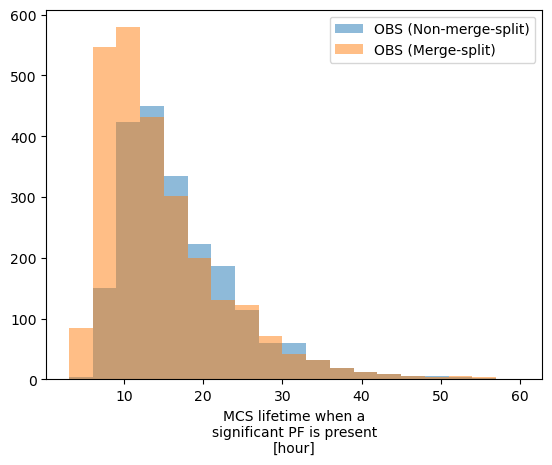

In [14]:
bins = np.arange(3,60.1,3)
ds_l_obs.isel(tracks=tid_l_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Non-merge-split)')
ds_l_obs.isel(tracks=tid_l_obs['ms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Merge-split)')
plt.legend()

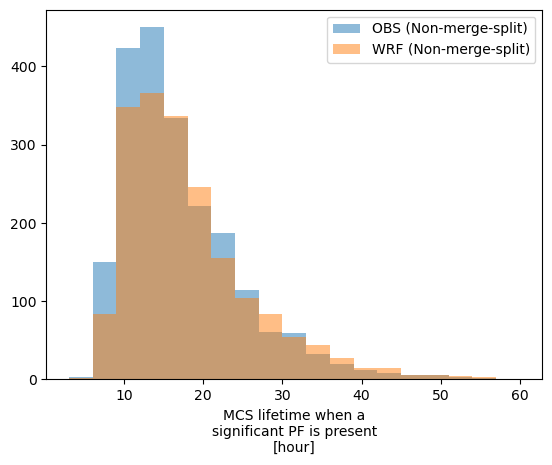

In [15]:
bins = np.arange(3,60.1,3)
ds_l_obs.isel(tracks=tid_l_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='OBS (Non-merge-split)')
ds_l_m1.isel(tracks=tid_l_m1['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5, label='WRF (Non-merge-split)')
plt.legend()

## Subset merge/split tracks

In [16]:
ds_nms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['nms'])
ds_nms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['nms'])
ds_ms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['ms'])
ds_ms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['ms'])
print(f"Number of non-merge-split tracks OBS (Land): {ds_nms_l_obs.dims['tracks']}")
print(f"Number of non-merge-split tracks OBS (Ocean): {ds_nms_o_obs.dims['tracks']}")
print(f"Number of merge-split tracks OBS (Land): {ds_ms_l_obs.dims['tracks']}")
print(f"Number of merge-split tracks OBS (Ocean): {ds_ms_o_obs.dims['tracks']}")

Number of non-merge-split tracks OBS (Land): 2090
Number of non-merge-split tracks OBS (Ocean): 150
Number of merge-split tracks OBS (Land): 2600
Number of merge-split tracks OBS (Ocean): 300


In [17]:
ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
ds_nms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
ds_ms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ms'])
ds_ms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ms'])
print(f"Number of non-merge-split tracks WRF (Land): {ds_nms_l_m1.dims['tracks']}")
print(f"Number of non-merge-split tracks WRF (Ocean): {ds_nms_o_m1.dims['tracks']}")
print(f"Number of merge-split tracks WRF (Land): {ds_ms_l_m1.dims['tracks']}")
print(f"Number of merge-split tracks WRF (Ocean): {ds_ms_o_m1.dims['tracks']}")

Number of non-merge-split tracks WRF (Land): 1897
Number of non-merge-split tracks WRF (Ocean): 123
Number of merge-split tracks WRF (Land): 2068
Number of merge-split tracks WRF (Ocean): 107


## Function to compute 1D KDE

In [18]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

### CCS Lifetime

In [19]:
lifetime_bins = np.linspace(0, 60, 1000)
# Ocean
kde_ccslifetime_nms_o_obs = get_kde1d((ds_nms_o_obs.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_o_m1 = get_kde1d((ds_nms_o_m1.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)
# Land
kde_ccslifetime_nms_l_obs = get_kde1d((ds_nms_l_obs.track_duration * time_res_obs).data, lifetime_bins, kde_bw=3)
kde_ccslifetime_nms_l_m1 = get_kde1d((ds_nms_l_m1.track_duration * time_res_m1).data, lifetime_bins, kde_bw=3)

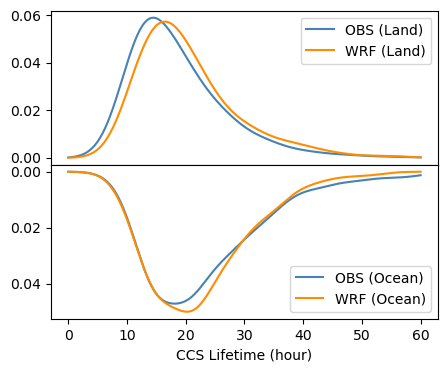

In [20]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(lifetime_bins, kde_ccslifetime_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('CCS Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### PF Lifetime

In [21]:
# Merge or split tracks
kde_pflifetime_ms_o_obs = get_kde1d(ds_ms_o_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_pflifetime_ms_o_m1 = get_kde1d(ds_ms_o_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)

# Non-merge & non-split tracks
# Ocean
kde_pflifetime_nms_o_obs = get_kde1d(ds_nms_o_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_o_m1 = get_kde1d(ds_nms_o_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)
# Land
kde_pflifetime_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_lifetime.data, lifetime_bins, kde_bw=3)
kde_pflifetime_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_lifetime.data, lifetime_bins, kde_bw=3)

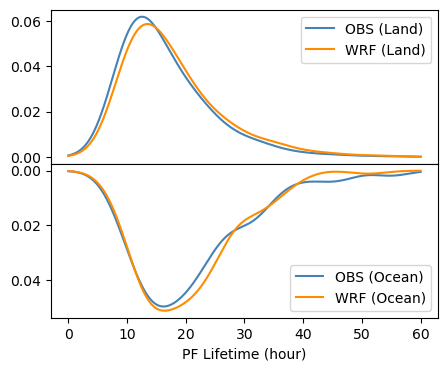

In [22]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(lifetime_bins, kde_pflifetime_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(lifetime_bins, kde_pflifetime_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(lifetime_bins, kde_pflifetime_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(lifetime_bins, kde_pflifetime_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('PF Lifetime (hour)')
fig.subplots_adjust(hspace=0)

### Max CCS Area

In [23]:
ccsarea_bins = np.linspace(4, 6.8, 1000)
# Add mergers/splits to get total CCS area
# Ocean
ccsarea_o_obs = ds_nms_o_obs.ccs_area + ds_nms_o_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_o_obs.split_ccs_area.sum(dim='mergers')
maxccsarea_o_obs = ccsarea_o_obs.max(dim='times')
ccsarea_o_m1 = ds_nms_o_m1.ccs_area + ds_nms_o_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m1.split_ccs_area.sum(dim='mergers')
maxccsarea_o_m1 = ccsarea_o_m1.max(dim='times')
# Land
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
maxccsarea_l_obs = ccsarea_l_obs.max(dim='times')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
maxccsarea_l_m1 = ccsarea_l_m1.max(dim='times')

# Ocean
kde_maxccsarea_nms_o_obs = get_kde1d(np.log10(maxccsarea_o_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_o_m1 = get_kde1d(np.log10(maxccsarea_o_m1.data), ccsarea_bins, kde_bw=0.2)
# Land
kde_maxccsarea_nms_l_obs = get_kde1d(np.log10(maxccsarea_l_obs.data), ccsarea_bins, kde_bw=0.2)
kde_maxccsarea_nms_l_m1 = get_kde1d(np.log10(maxccsarea_l_m1.data), ccsarea_bins, kde_bw=0.2)

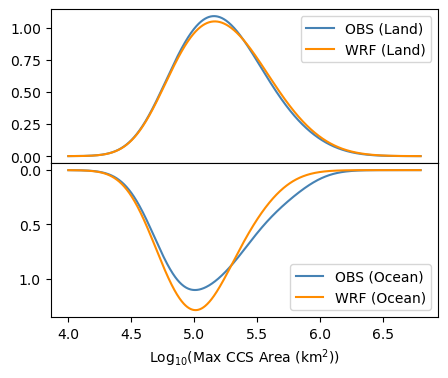

In [24]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(ccsarea_bins, kde_maxccsarea_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max CCS Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Lifetime-average min Tb

In [25]:
avgmintb_bins = np.linspace(180, 230, 1000)
# Ocean
kde_avgmintb_nms_o_obs = get_kde1d(ds_nms_o_obs.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_o_m1 = get_kde1d(ds_nms_o_m1.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
# Land
kde_avgmintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)
kde_avgmintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.mean(dim='times').data, avgmintb_bins, kde_bw=2)

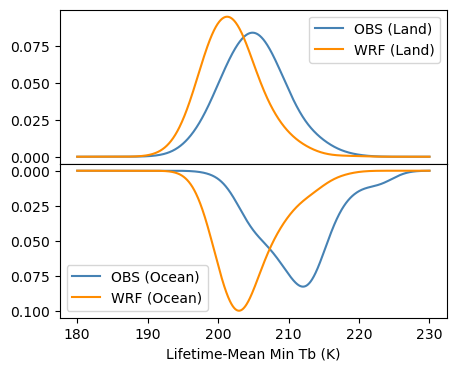

In [26]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(avgmintb_bins, kde_avgmintb_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(avgmintb_bins, kde_avgmintb_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-Mean Min Tb (K)')
fig.subplots_adjust(hspace=0)

### Lifetime-min Min Tb

In [27]:
mintb_bins = np.linspace(170, 220, 1000)
# Ocean
kde_mintb_nms_o_obs = get_kde1d(ds_nms_o_obs.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_o_m1 = get_kde1d(ds_nms_o_m1.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
# Land
kde_mintb_nms_l_obs = get_kde1d(ds_nms_l_obs.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)
kde_mintb_nms_l_m1 = get_kde1d(ds_nms_l_m1.corecold_mintb.min(dim='times').data, mintb_bins, kde_bw=2)

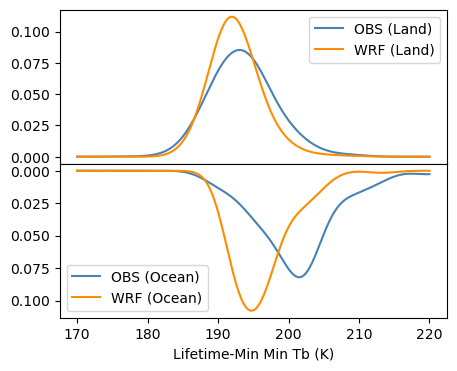

In [28]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(mintb_bins, kde_mintb_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(mintb_bins, kde_mintb_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(mintb_bins, kde_mintb_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(mintb_bins, kde_mintb_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-Min Min Tb (K)')
fig.subplots_adjust(hspace=0)

### Max PF Area

In [29]:
pfarea_bins = np.linspace(3.3, 6, 1000)
# Sum all PFs at a given time, then take max during lifetime
# Ocean
maxpfarea_o_obs = ds_nms_o_obs.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_o_m1 = ds_nms_o_m1.pf_area.sum(dim='nmaxpf').max(dim='times')
# Land
maxpfarea_l_obs = ds_nms_l_obs.pf_area.sum(dim='nmaxpf').max(dim='times')
maxpfarea_l_m1 = ds_nms_l_m1.pf_area.sum(dim='nmaxpf').max(dim='times')

# Ocean
kde_maxpfarea_nms_o_obs = get_kde1d(np.log10(maxpfarea_o_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_o_m1 = get_kde1d(np.log10(maxpfarea_o_m1.data), pfarea_bins, kde_bw=0.2)
# Land
kde_maxpfarea_nms_l_obs = get_kde1d(np.log10(maxpfarea_l_obs.data), pfarea_bins, kde_bw=0.2)
kde_maxpfarea_nms_l_m1 = get_kde1d(np.log10(maxpfarea_l_m1.data), pfarea_bins, kde_bw=0.2)

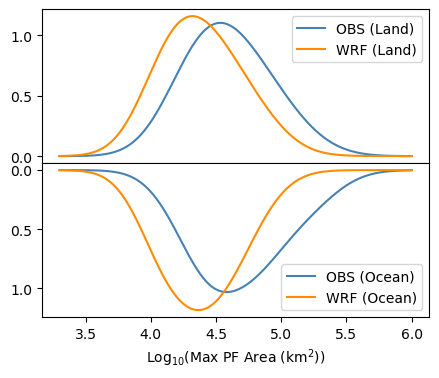

In [30]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(pfarea_bins, kde_maxpfarea_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Max PF Area (km$^2$))')
fig.subplots_adjust(hspace=0)

### Mean PF Rain Rate

In [31]:
pfrainrate_bins = np.linspace(2, 16, 1000)
# Ocean
kde_meanpfrainrate_nms_o_obs = get_kde1d(ds_nms_o_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_o_m1 = get_kde1d(ds_nms_o_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
# Land
kde_meanpfrainrate_nms_l_obs = get_kde1d(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)
kde_meanpfrainrate_nms_l_m1 = get_kde1d(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, pfrainrate_bins, kde_bw=0.5)

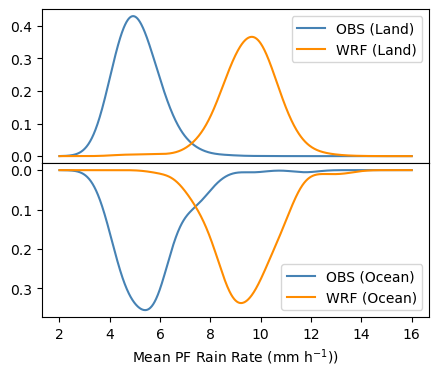

In [32]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(pfrainrate_bins, kde_meanpfrainrate_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Mean PF Rain Rate (mm h$^{-1}$))')
fig.subplots_adjust(hspace=0)

### Lifetime-total Rain Volume

In [33]:
# Lifetime total rain volume [unit: kg]
# Ocean
pfvolrain_o_obs = ds_nms_o_obs.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_o_m1 = ds_nms_o_m1.total_rain.sum(dim='times') * pixel_radius_m1**2
# Land
pfvolrain_l_obs = ds_nms_l_obs.total_rain.sum(dim='times') * pixel_radius_obs**2
pfvolrain_l_m1 = ds_nms_l_m1.total_rain.sum(dim='times') * pixel_radius_m1**2

volrain_bins = np.linspace(5, 8.5, 1000)
# Ocean
kde_pfvolrain_nms_o_obs = get_kde1d(np.log10(pfvolrain_o_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_o_m1 = get_kde1d(np.log10(pfvolrain_o_m1.data), volrain_bins, kde_bw=0.2)
# Land
kde_pfvolrain_nms_l_obs = get_kde1d(np.log10(pfvolrain_l_obs.data), volrain_bins, kde_bw=0.2)
kde_pfvolrain_nms_l_m1 = get_kde1d(np.log10(pfvolrain_l_m1.data), volrain_bins, kde_bw=0.2)

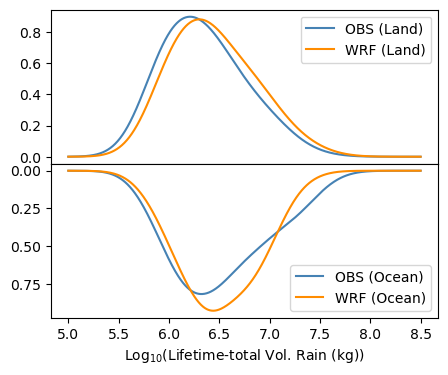

In [34]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(volrain_bins, kde_pfvolrain_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(volrain_bins, kde_pfvolrain_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(volrain_bins, kde_pfvolrain_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(volrain_bins, kde_pfvolrain_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Lifetime-total Vol. Rain (kg))')
fig.subplots_adjust(hspace=0)

### Heavy rain volume

In [35]:
# Lifetime total heavy rain volume [unit: kg]
# Ocean
pfheavyvolrain_o_obs = ds_nms_o_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_o_m1 = ds_nms_o_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2
# Land
pfheavyvolrain_l_obs = ds_nms_l_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2
pfheavyvolrain_l_m1 = ds_nms_l_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2

heavyvolrain_bins = np.linspace(4, 8, 1000)
# Ocean
kde_pfheavyvolrain_nms_o_obs = get_kde1d(np.log10(pfheavyvolrain_o_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_o_m1 = get_kde1d(np.log10(pfheavyvolrain_o_m1.data), heavyvolrain_bins, kde_bw=0.2)
# Land
kde_pfheavyvolrain_nms_l_obs = get_kde1d(np.log10(pfheavyvolrain_l_obs.data), heavyvolrain_bins, kde_bw=0.2)
kde_pfheavyvolrain_nms_l_m1 = get_kde1d(np.log10(pfheavyvolrain_l_m1.data), heavyvolrain_bins, kde_bw=0.2)

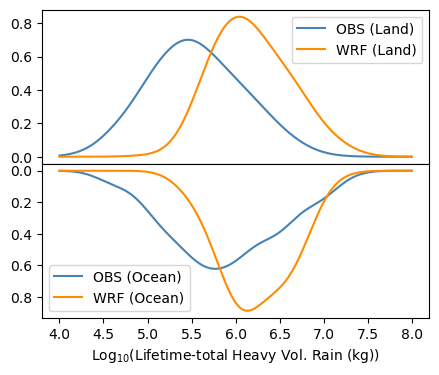

In [36]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(heavyvolrain_bins, kde_pfheavyvolrain_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Log$_{10}$(Lifetime-total Heavy Vol. Rain (kg))')
fig.subplots_adjust(hspace=0)

### Heavy Rain Volume Ratio

In [37]:
# Heavy rain volume ratio (heavy rain vol. / total rain vol.)
# Ocean
pfhrr_nms_o_obs = 100 * pfheavyvolrain_o_obs / pfvolrain_o_obs
pfhrr_nms_o_m1 = 100 * pfheavyvolrain_o_m1 / pfvolrain_o_m1
# Land
pfhrr_nms_l_obs = 100 * pfheavyvolrain_l_obs / pfvolrain_l_obs
pfhrr_nms_l_m1 = 100 * pfheavyvolrain_l_m1 / pfvolrain_l_m1

pfhrr_bins = np.linspace(0, 100, 1000)
# Ocean
kde_pfhrr_nms_o_obs = get_kde1d(pfhrr_nms_o_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_o_m1 = get_kde1d(pfhrr_nms_o_m1.data, pfhrr_bins, kde_bw=4)
# Land
kde_pfhrr_nms_l_obs = get_kde1d(pfhrr_nms_l_obs.data, pfhrr_bins, kde_bw=4)
kde_pfhrr_nms_l_m1 = get_kde1d(pfhrr_nms_l_m1.data, pfhrr_bins, kde_bw=4)

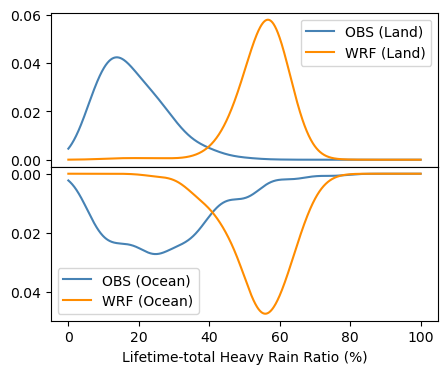

In [38]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(pfhrr_bins, kde_pfhrr_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(pfhrr_bins, kde_pfhrr_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Lifetime-total Heavy Rain Ratio (%)')
fig.subplots_adjust(hspace=0)

### MCS Lifetime-median PF Movement Speed

In [39]:
# PF movement speed
pfspeed_bins = np.linspace(0, 20, 1000)
# Ocean
kde_pfspeed_nms_o_obs = get_kde1d(ds_nms_o_obs.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_o_m1 = get_kde1d(ds_nms_o_m1.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
# Land
kde_pfspeed_nms_l_obs = get_kde1d(ds_nms_l_obs.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)
kde_pfspeed_nms_l_m1 = get_kde1d(ds_nms_l_m1.movement_speed.median(dim='times').data, pfspeed_bins, kde_bw=2)

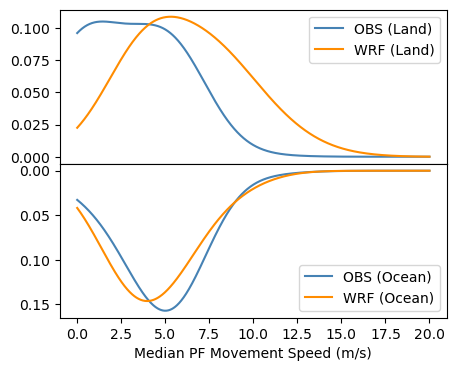

In [40]:
fig, axes = plt.subplots(2, 1, figsize=[5,4], dpi=100, sharex=True)
ax = axes[0]
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_obs, 'steelblue', label='OBS (Land)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_l_m1, 'darkorange', label='WRF (Land)')
ax.legend()
ax = axes[1]
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_obs, 'steelblue', label='OBS (Ocean)')
ax.plot(pfspeed_bins, kde_pfspeed_nms_o_m1, 'darkorange', label='WRF (Ocean)')
ax.invert_yaxis()
ax.legend()
ax.set_xlabel('Median PF Movement Speed (m/s)')
fig.subplots_adjust(hspace=0)

## Put variables into dictionary for plotting

In [41]:
# Ocean variables
ccslifetime_o_dict = {
    'obs':kde_ccslifetime_nms_o_obs,
    'm1': kde_ccslifetime_nms_o_m1,
}
pfspeed_o_dict = {
    'obs': kde_pfspeed_nms_o_obs,
    'm1': kde_pfspeed_nms_o_m1,
}
ccsarea_o_dict = {
    'obs': kde_maxccsarea_nms_o_obs,
    'm1': kde_maxccsarea_nms_o_m1,
}
mintb_o_dict = {
    'obs': kde_avgmintb_nms_o_obs,
    'm1': kde_avgmintb_nms_o_m1,
}
pfarea_o_dict = {
    'obs': kde_maxpfarea_nms_o_obs,
    'm1': kde_maxpfarea_nms_o_m1,
}
pfrainrate_o_dict = {
    'obs': kde_meanpfrainrate_nms_o_obs,
    'm1': kde_meanpfrainrate_nms_o_m1,
}
volrain_o_dict = {
    'obs': kde_pfvolrain_nms_o_obs,
    'm1': kde_pfvolrain_nms_o_m1,
}
heavyvolrain_o_dict = {
    'obs': kde_pfheavyvolrain_nms_o_obs,
    'm1': kde_pfheavyvolrain_nms_o_m1,
}
hrr_o_dict = {
    'obs': kde_pfhrr_nms_o_obs,
    'm1': kde_pfhrr_nms_o_m1,
}

# Land variables
ccslifetime_l_dict = {
    'obs':kde_ccslifetime_nms_l_obs,
    'm1': kde_ccslifetime_nms_l_m1,
}
pfspeed_l_dict = {
    'obs': kde_pfspeed_nms_l_obs,
    'm1': kde_pfspeed_nms_l_m1,
}
ccsarea_l_dict = {
    'obs': kde_maxccsarea_nms_l_obs,
    'm1': kde_maxccsarea_nms_l_m1,
}
mintb_l_dict = {
    'obs': kde_avgmintb_nms_l_obs,
    'm1': kde_avgmintb_nms_l_m1,
}
pfarea_l_dict = {
    'obs': kde_maxpfarea_nms_l_obs,
    'm1': kde_maxpfarea_nms_l_m1,
}
pfrainrate_l_dict = {
    'obs': kde_meanpfrainrate_nms_l_obs,
    'm1': kde_meanpfrainrate_nms_l_m1,
}
volrain_l_dict = {
    'obs': kde_pfvolrain_nms_l_obs,
    'm1': kde_pfvolrain_nms_l_m1,
}
heavyvolrain_l_dict = {
    'obs': kde_pfheavyvolrain_nms_l_obs,
    'm1': kde_pfheavyvolrain_nms_l_m1,
}
hrr_l_dict = {
    'obs': kde_pfhrr_nms_l_obs,
    'm1': kde_pfhrr_nms_l_m1,
}

## Function to plot mirror 1D KDE on (m row x n column) panels

In [42]:
def plot_pdf_mirror_mxn(nrow, ncol, nrowsub, ncolsub, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=None,
                fontsize=None, xscale=None, yscale=None, xlims=None, ylims=None, label_topbot=None, label_pos=None,
                legend_fontsize=11, legend_loc=None, legend_ncol=None, figsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    lw = 3
    lcolors = {
        'obs':'steelblue', 
        'm1': 'darkorange',
    }
    
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.3)

    for row in range(nrow):
        for col in range(ncol):
            # gridspec inside gridspec
            inner_grid = outer_grid[row, col].subgridspec(nrowsub, ncolsub, wspace=0, hspace=0)
            axs = inner_grid.subplots()
            ax1 = axs[0]  # top
            ax2 = axs[1]  # bottom
            ax2.invert_yaxis()
            # Top panel
            ax1.plot(bins[row][col], data_top[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax1.plot(bins[row][col], data_top[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Bottom panel
            ax2.plot(bins[row][col], data_bot[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax2.plot(bins[row][col], data_bot[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Labels, gridlines, etc.
            ax1.grid(which='major', ls='--')
            ax2.grid(which='major', ls='--')
            ax1.set_title(titles[row][col], loc='left')
            ax2.set_xlabel(xlabels[row][col])
            # Hide x axis label marks
            ax1.tick_params(labelbottom=False) 
            # Label top/bottom panels
            ax1.text(label_pos['top']['x'], label_pos['top']['y'], label_topbot['top'], ha='left', transform=ax1.transAxes)
            ax2.text(label_pos['bottom']['x'], label_pos['bottom']['y'], label_topbot['bottom'], ha='left', transform=ax2.transAxes)
            # Label yaxis, legend
            if (col == 0):
                ax1.legend(fontsize=legend_fontsize, loc=legend_loc[0], ncol=legend_ncol[0])
                ax1.text(-0.25, 1, ylabels[row][col], va='center', ha='center', rotation=90, transform=ax2.transAxes)           
            
            # Plot inset map
            if (row == map_panel['row']) & (col == map_panel['col']) & (map_panel['rowsub'] == 0) & (map_panel['colsub'] == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax1, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

## Setup legends, inset map

In [43]:
legends = {
    'obs': 'OBS',
    'm1': 'WRF',
}
# Inset map settings
map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
inset_param = {'width':'40%', 'height':'40%', 'loc':'upper right', 'borderpad':0.1}
map_extent, lonbox, latbox

([-80, -25, -30, 20], [-70, -36], [-20, 10])

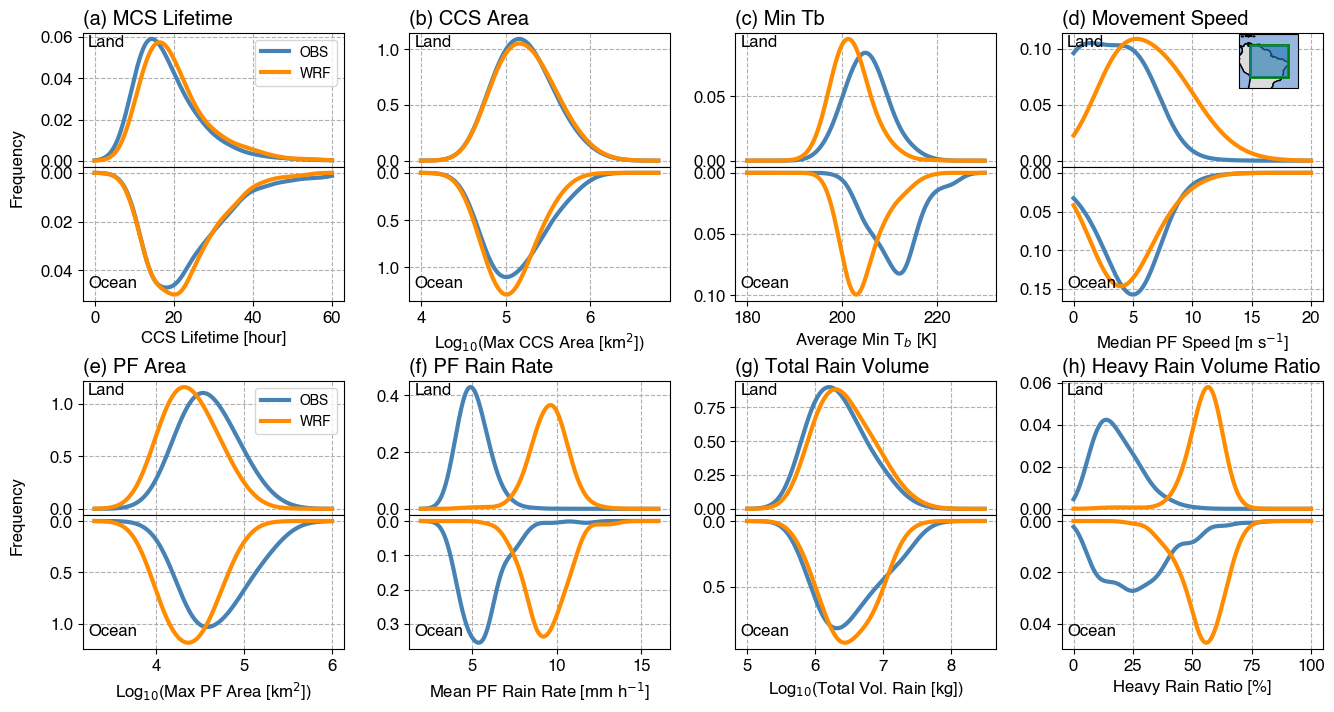

In [44]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_top = [
    [ccslifetime_l_dict, ccsarea_l_dict, mintb_l_dict, pfspeed_l_dict], 
    [pfarea_l_dict, pfrainrate_l_dict, volrain_l_dict, hrr_l_dict, ],
]
data_bot = [
    [ccslifetime_o_dict, ccsarea_o_dict, mintb_o_dict, pfspeed_o_dict], 
    [pfarea_o_dict, pfrainrate_o_dict, volrain_o_dict, hrr_o_dict, ],
]
titles = [
    ['(a) MCS Lifetime', '(b) CCS Area', '(c) Min Tb', '(d) Movement Speed'],
    ['(e) PF Area', '(f) PF Rain Rate', '(g) Total Rain Volume', '(h) Heavy Rain Volume Ratio'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'Median PF Speed [m s$^{-1}$]', ],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
label_topbot = {'top':'Land', 'bottom':'Ocean'}
label_pos = {'top':{'x':0.02, 'y':0.9}, 'bottom':{'x':0.02, 'y':0.1}}
legend_loc = ['upper right', 'upper right']
legend_ncol = [1, 1]
map_panel = {'row': 0, 'col': 3, 'rowsub': 0, 'colsub': 0}
figname = f'{figdir}kde1d_mcs_ocean_land_2x4_{region}.png'
fig = plot_pdf_mirror_mxn(2, 4, 2, 1, bins, data_top, data_bot, titles, xlabels, ylabels, legends, figname,
                          fontsize=12, map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=map_panel,
                          legend_fontsize=10, legend_loc=legend_loc, legend_ncol=legend_ncol, label_topbot=label_topbot, label_pos=label_pos, 
                          figsize=[16,8])

## Function to plot 1D KDE on (m x n) panels

In [45]:
def plot_pdf_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                fontsize=12, legend_fontsize=11, legend_loc='best', figsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig = plt.figure(figsize=figsize, constrained_layout=False, dpi=100)
    outer_grid = fig.add_gridspec(nrow, ncol, wspace=0.25, hspace=0.35)

    lw = 3
    lcolors = {
        'obs':'steelblue', 
        'm1': 'darkorange',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = plt.subplot(outer_grid[row,col])
            ax.plot(bins[row][col], data_arr[row][col]['obs'], lcolors['obs'], lw=lw, label=legends['obs'])
            ax.plot(bins[row][col], data_arr[row][col]['m1'], lcolors['m1'], lw=lw, label=legends['m1'])
            # Labels
            if (col == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row][col])
            # if (col == 0):
            ax.set_ylabel(ylabels[row][col])
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
                # proj = ccrs.PlateCarree(central_longitude=180)
                proj = ccrs.PlateCarree(central_longitude=0)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                sub_ax.add_feature(states, edgecolor='k', facecolor='none', zorder=4)
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
                x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
                # Plot rectangle
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, edgecolor='g', zorder=10))
                sub_ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill='g', edgecolor=None, alpha=0.6, zorder=10))

    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

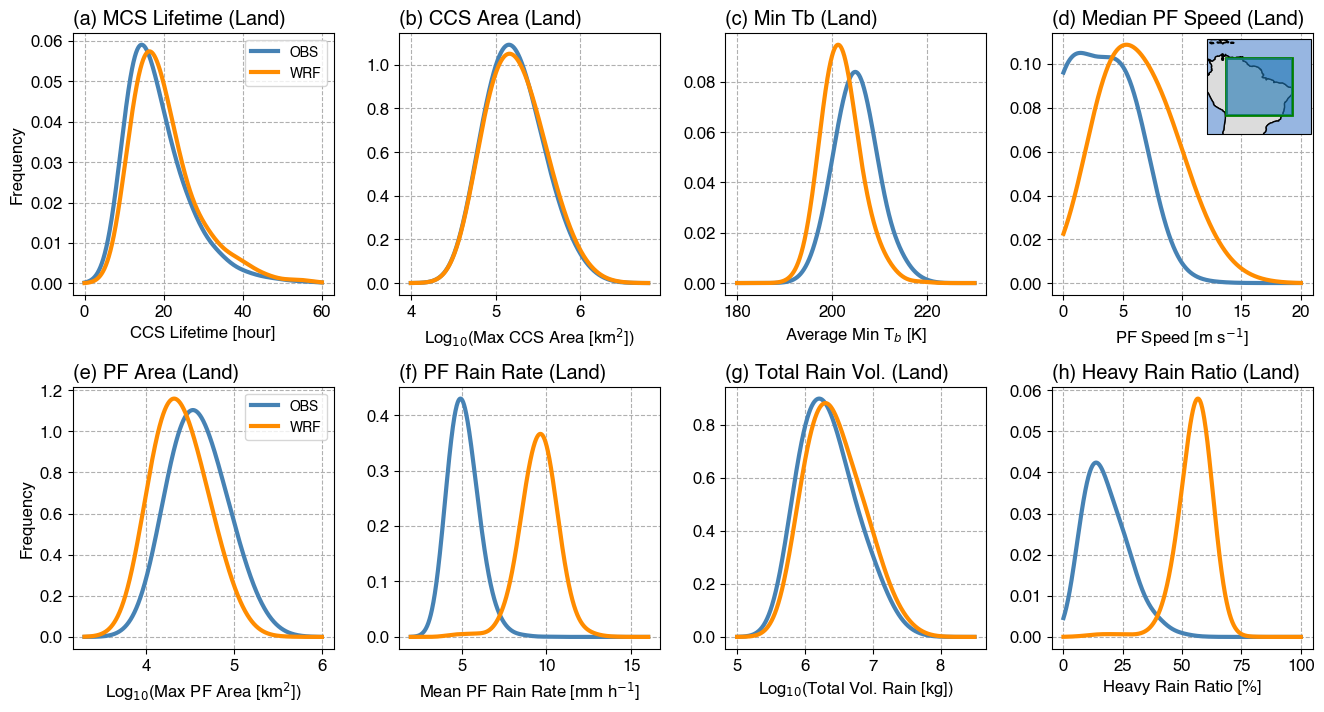

In [46]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_l_dict, ccsarea_l_dict, mintb_l_dict, pfspeed_l_dict], 
    [pfarea_l_dict, pfrainrate_l_dict, volrain_l_dict, hrr_l_dict, ],
]
titles = [
    ['(a) MCS Lifetime (Land)', '(b) CCS Area (Land)', '(c) Min Tb (Land)', '(d) Median PF Speed (Land)'],
    ['(e) PF Area (Land)', '(f) PF Rain Rate (Land)', '(g) Total Rain Vol. (Land)', '(h) Heavy Rain Ratio (Land)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_land_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[16,8])

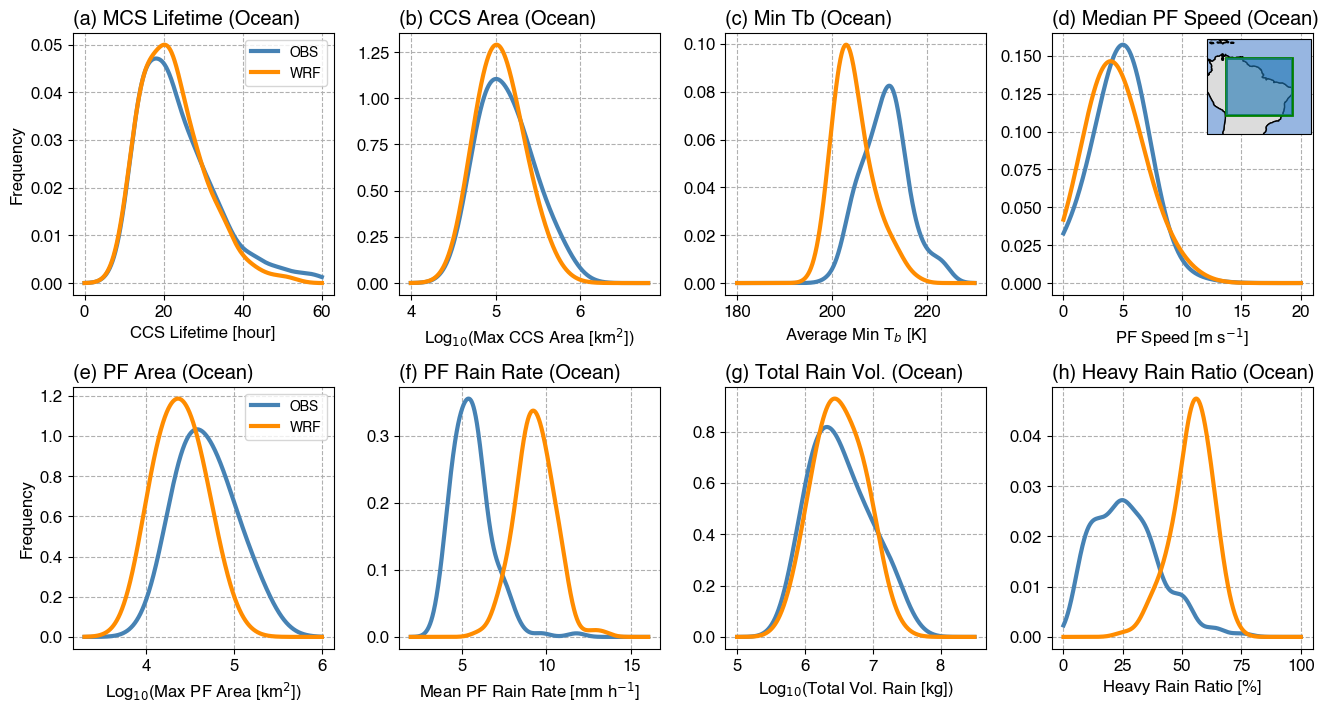

In [47]:
bins = [
    [lifetime_bins, ccsarea_bins, avgmintb_bins, pfspeed_bins],
    [pfarea_bins, pfrainrate_bins, volrain_bins, pfhrr_bins],    
]
data_arr = [
    [ccslifetime_o_dict, ccsarea_o_dict, mintb_o_dict, pfspeed_o_dict], 
    [pfarea_o_dict, pfrainrate_o_dict, volrain_o_dict, hrr_o_dict, ],
]
titles = [
    ['(a) MCS Lifetime (Ocean)', '(b) CCS Area (Ocean)', '(c) Min Tb (Ocean)', '(d) Median PF Speed (Ocean)'],
    ['(e) PF Area (Ocean)', '(f) PF Rain Rate (Ocean)', '(g) Total Rain Vol. (Ocean)', '(h) Heavy Rain Ratio (Ocean)'],
]
xlabels = [
    ['CCS Lifetime [hour]', 'Log$_{10}$(Max CCS Area [km$^2$])', 'Average Min T$_b$ [K]', 'PF Speed [m s$^{-1}$]'],
    ['Log$_{10}$(Max PF Area [km$^2$])', 'Mean PF Rain Rate [mm h$^{-1}$]', 'Log$_{10}$(Total Vol. Rain [kg])', 'Heavy Rain Ratio [%]'],
]
ylabels = [['Frequency','','',''], ['Frequency','','','']]
figname = f'{figdir}kde1d_mcs_ocean_2x4_{region}.png'
fig = plot_pdf_mxn(2, 4, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,3],
                   legend_fontsize=10, legend_loc='best', figsize=[16,8])

In [48]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'

## Function to composite track time-evolution by 1 condition

In [49]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]), drop=True)
        nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

## Composite MCS time-evolution by CCS lifetime (for non-merge-split tracks only)
- Note the use of Dataset (ds_nms)

In [50]:
# Set lifetime range for composites
lifetime_range1 = [9, 12]
lifetime_range2 = [20, 24]
quantiles = [0.25, 0.5, 0.75]

# Add mergers/splits to get total CCS area
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
# CCS lifetime
ccslifetime_l_obs = ds_nms_l_obs.track_duration * time_res_obs
ccslifetime_l_m1 = ds_nms_l_m1.track_duration * time_res_m1

# CCS Area
avg1_ccsarea_l_obs, qntl1_ccsarea_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ccsarea_l_obs, ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_ccsarea_l_obs, qntl2_ccsarea_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ccsarea_l_obs, ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_ccsarea_l_m1, qntl1_ccsarea_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ccsarea_l_m1, ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_ccsarea_l_m1, qntl2_ccsarea_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ccsarea_l_m1, ccslifetime_l_m1, lifetime_range2, quantiles)
print(f'Sample number (range1): {ns1_l_obs} (OBS), {ns1_l_m1} (WRF)')
print(f'Sample number (range2): {ns2_l_obs} (OBS), {ns2_l_m1} (WRF)')

Sample number (range1): 411 (OBS), 244 (WRF)
Sample number (range2): 351 (OBS), 390 (WRF)


In [51]:
# Min Tb
avg1_mintb_l_obs, qntl1_mintb_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.corecold_mintb, ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_mintb_l_obs, qntl2_mintb_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.corecold_mintb, ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_mintb_l_m1, qntl1_mintb_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.corecold_mintb, ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_mintb_l_m1, qntl2_mintb_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.corecold_mintb, ccslifetime_l_m1, lifetime_range2, quantiles)

In [52]:
# Largest PF Area
avg1_pfarea_l_obs, qntl1_pfarea_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_area.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_pfarea_l_obs, qntl2_pfarea_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_area.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_pfarea_l_m1, qntl1_pfarea_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_area.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_pfarea_l_m1, qntl2_pfarea_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_area.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range2, quantiles)

In [53]:
# Largest PF Equivalent Diameter
avg1_pfdiam_l_obs, qntl1_pfdiam_l_obs, ns1_l_obs = get_comp_tracks_by1cond(2*np.sqrt(ds_nms_l_obs.pf_area.isel(nmaxpf=0) / np.pi), ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_pfdiam_l_obs, qntl2_pfdiam_l_obs, ns2_l_obs = get_comp_tracks_by1cond(2*np.sqrt(ds_nms_l_obs.pf_area.isel(nmaxpf=0) / np.pi), ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_pfdiam_l_m1, qntl1_pfdiam_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(2*np.sqrt(ds_nms_l_m1.pf_area.isel(nmaxpf=0) / np.pi), ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_pfdiam_l_m1, qntl2_pfdiam_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(2*np.sqrt(ds_nms_l_m1.pf_area.isel(nmaxpf=0) / np.pi), ccslifetime_l_m1, lifetime_range2, quantiles)

In [54]:
# Largest PF Rain Rate
avg1_pfrainrate_l_obs, qntl1_pfrainrate_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_pfrainrate_l_obs, qntl2_pfrainrate_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_pfrainrate_l_m1, qntl1_pfrainrate_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_pfrainrate_l_m1, qntl2_pfrainrate_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range2, quantiles)

In [55]:
# Volume Rain Rate [kg/h]
avg1_pfvolrain_l_obs, qntl1_pfvolrain_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.total_rain * pixel_radius_obs**2, ccslifetime_l_obs, lifetime_range1, quantiles)
avg2_pfvolrain_l_obs, qntl2_pfvolrain_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.total_rain * pixel_radius_obs**2, ccslifetime_l_obs, lifetime_range2, quantiles)

avg1_pfvolrain_l_m1, qntl1_pfvolrain_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.total_rain * pixel_radius_m1**2, ccslifetime_l_m1, lifetime_range1, quantiles)
avg2_pfvolrain_l_m1, qntl2_pfvolrain_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.total_rain * pixel_radius_m1**2, ccslifetime_l_m1, lifetime_range2, quantiles)

## Function to plot composite track time-evolution variables

In [56]:
def plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                            titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                            map_extent, lon_box, lat_box, inset_param, figname,
                            legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=[10,12], dpi=100)

    colors = {'o':'steelblue', 'm':'darkorange'}

    for row in range(0,5):
        for col in range(0,2): 
            ax = axes[row][col]           
            ax.plot(hours_obs[col], dataavg_obs[row][col], colors['o'], lw=3, label=legends[col]['o'])
            ax.plot(hours_m1[col], dataavg_m1[row][col], colors['m'], lw=3, label=legends[col]['m'])
            ax.fill_between(hours_obs[col], dataqntl_obs[row][col][0], dataqntl_obs[row][col][1], facecolor=colors['o'],  alpha=0.3)
            ax.fill_between(hours_m1[col], dataqntl_m1[row][col][0], dataqntl_m1[row][col][1], facecolor=colors['m'],  alpha=0.3)

            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

/tmp/ipykernel_2160122/4139627217.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


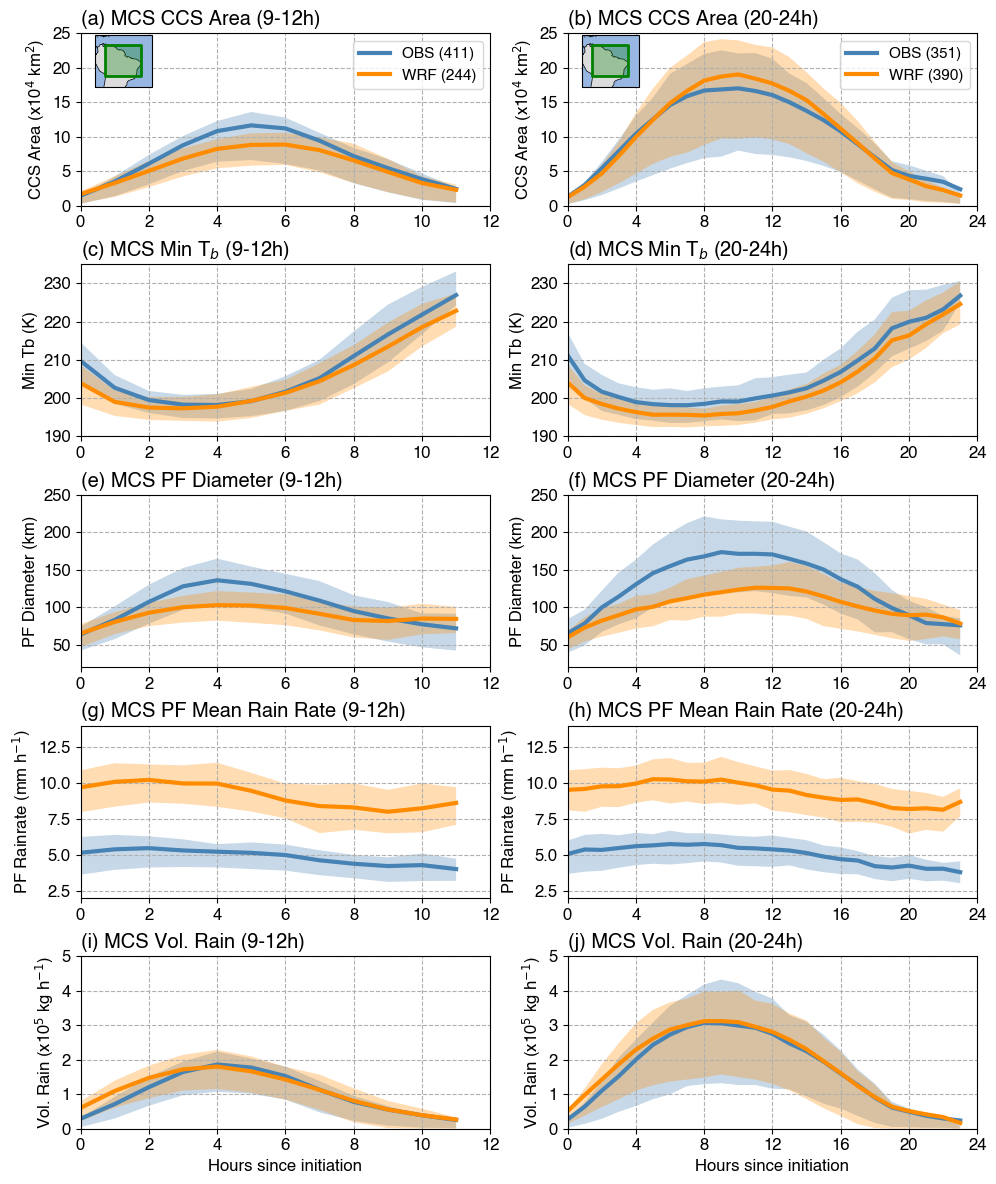

In [57]:
hours_obs = [avg1_ccsarea_l_obs.times, avg2_ccsarea_l_obs.times]
hours_m1 = [avg1_ccsarea_l_m1.times, avg2_ccsarea_l_m1.times]
dataavg_obs = [[avg1_ccsarea_l_obs/1e4, avg2_ccsarea_l_obs/1e4],
            [avg1_mintb_l_obs, avg2_mintb_l_obs],
            [avg1_pfdiam_l_obs, avg2_pfdiam_l_obs], 
            [avg1_pfrainrate_l_obs, avg2_pfrainrate_l_obs],
            [avg1_pfvolrain_l_obs/1e5, avg2_pfvolrain_l_obs/1e5]]
dataavg_m1 = [[avg1_ccsarea_l_m1/1e4, avg2_ccsarea_l_m1/1e4],
            [avg1_mintb_l_m1, avg2_mintb_l_m1],
            [avg1_pfdiam_l_m1, avg2_pfdiam_l_m1], 
            [avg1_pfrainrate_l_m1, avg2_pfrainrate_l_m1],
            [avg1_pfvolrain_l_m1/1e5, avg2_pfvolrain_l_m1/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_l_obs.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_obs.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_obs.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_obs.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_obs.sel(quantile=0.25),qntl1_mintb_l_obs.sel(quantile=0.75)), 
                 (qntl2_mintb_l_obs.sel(quantile=0.25),qntl2_mintb_l_obs.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_obs.sel(quantile=0.25),qntl1_pfdiam_l_obs.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_obs.sel(quantile=0.25),qntl2_pfdiam_l_obs.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_obs.sel(quantile=0.25),qntl1_pfrainrate_l_obs.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_obs.sel(quantile=0.25),qntl2_pfrainrate_l_obs.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_obs.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_obs.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_obs.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_obs.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_l_m1.sel(quantile=0.25)/1e4,qntl1_ccsarea_l_m1.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_l_m1.sel(quantile=0.25)/1e4,qntl2_ccsarea_l_m1.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_l_m1.sel(quantile=0.25),qntl1_mintb_l_m1.sel(quantile=0.75)), 
                 (qntl2_mintb_l_m1.sel(quantile=0.25),qntl2_mintb_l_m1.sel(quantile=0.75))],
                [(qntl1_pfdiam_l_m1.sel(quantile=0.25),qntl1_pfdiam_l_m1.sel(quantile=0.75)), 
                 (qntl2_pfdiam_l_m1.sel(quantile=0.25),qntl2_pfdiam_l_m1.sel(quantile=0.75))],
                [(qntl1_pfrainrate_l_m1.sel(quantile=0.25),qntl1_pfrainrate_l_m1.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_l_m1.sel(quantile=0.25),qntl2_pfrainrate_l_m1.sel(quantile=0.75))],
                [(qntl1_pfvolrain_l_m1.sel(quantile=0.25)/1e5,qntl1_pfvolrain_l_m1.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_l_m1.sel(quantile=0.25)/1e5,qntl2_pfvolrain_l_m1.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_l_obs, ns2_l_obs]
ns_m1 = [ns1_l_m1, ns2_l_m1]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(e) MCS PF Diameter ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(f) MCS PF Diameter ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(g) MCS PF Mean Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(h) MCS PF Mean Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(j) MCS Vol. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h)']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,25), (190,235), (20,250), (2,14), (0,5)]
legends = [{'o':f'OBS ({ns1_l_obs})', 'm':f'WRF ({ns1_l_m1})'}, {'o':f'OBS ({ns2_l_obs})', 'm':f'WRF ({ns2_l_m1})'}]
figname = f'{figdir}mcs_composite_evolution_{region}_land.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                              titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                              map_extent, lon_bounds, lat_bounds, inset_param, figname, legend_loc='upper right')

In [58]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'

In [59]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [60]:
# Set Seaborn plot style
sns.set_theme('talk', style='whitegrid', font_scale=1.3, 
              rc={'lines.linewidth':5, 'font.family':'Helvetica', 'axes.edgecolor':'k', 'grid.linestyle':'--'})
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': 'k',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '--',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['Helvetica'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Function to plot 2D KDE

In [61]:
def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, 
                   legend_loc='lower right', legend_labels=None):
    mpl.rcParams['font.family'] = 'Helvetica'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    # legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

## Land

In [62]:
levels = [0.1,0.2,0.4,0.6,0.8,1]
legend_labels = ['OBS', 'WRF']
annotate_text = f'{region} (Land)'

/tmp/ipykernel_2160122/2883991959.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


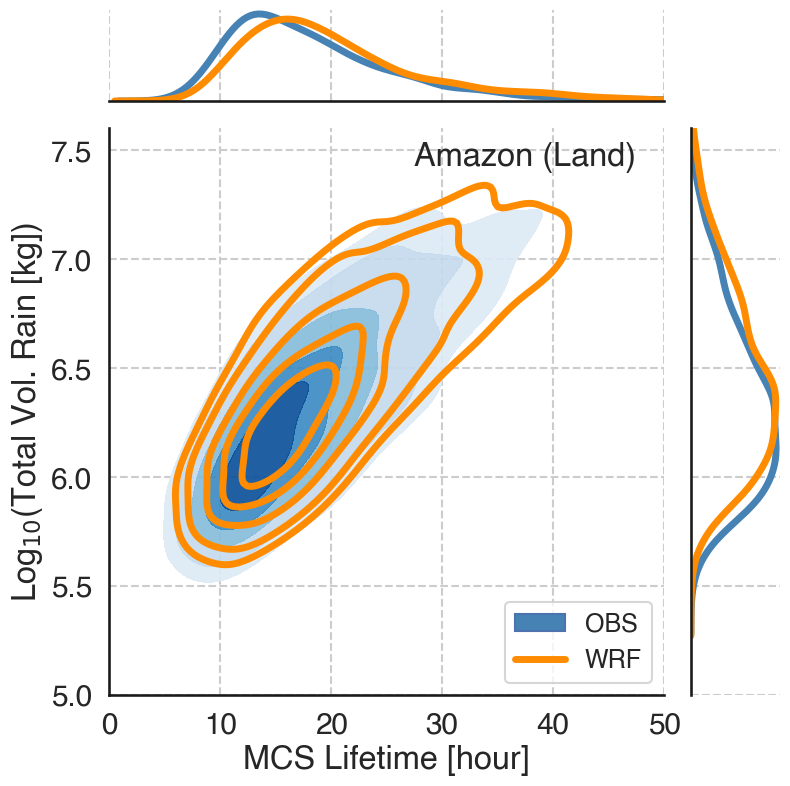

In [63]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(pfvolrain_l_obs).data
x_m1, y_m1 = (ds_nms_l_m1.track_duration * time_res_m1).data, np.log10(pfvolrain_l_m1).data
xlim = (0,50)
ylim = (5.0,7.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_{region}_land_imerg_wrf.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

/tmp/ipykernel_2160122/2883991959.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


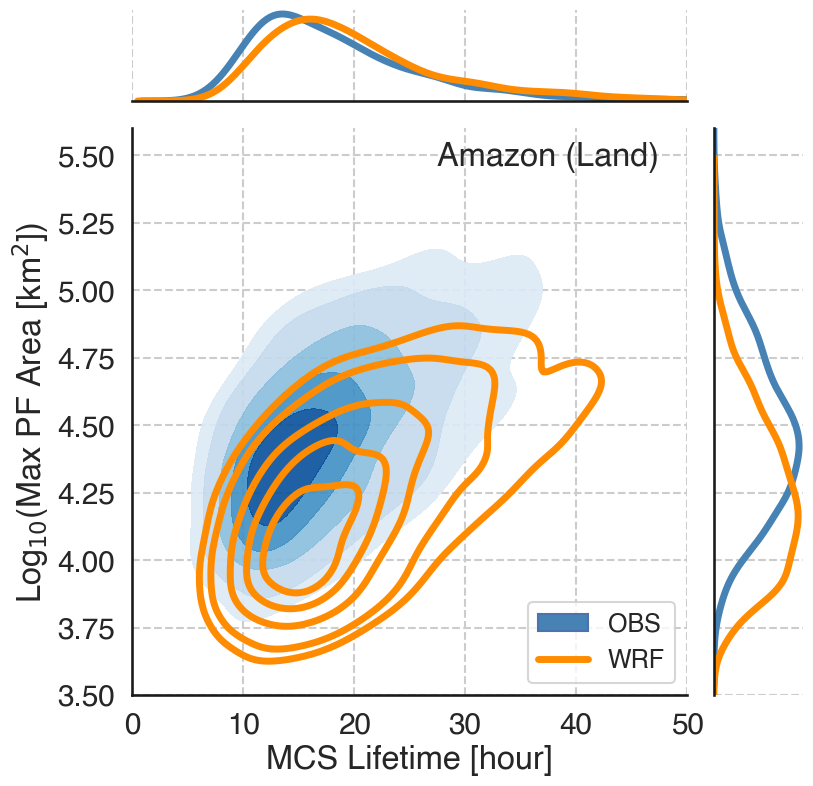

In [64]:
x_obs, y_obs = (ds_nms_l_obs.track_duration * time_res_obs).data, np.log10(ds_nms_l_obs.pf_area.max(dim=('times','nmaxpf'))).data
x_m1, y_m1 = (ds_nms_l_m1.track_duration * time_res_obs).data, np.log10(ds_nms_l_m1.pf_area.max(dim=('times','nmaxpf'))).data
xlim = (0,50)
ylim = (3.5,5.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Max PF Area [km$^2$])'
figname = f'{figdir}JointDist_Lifetime_PFarea_{region}_land_imerg_wrf.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

/tmp/ipykernel_2160122/2883991959.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


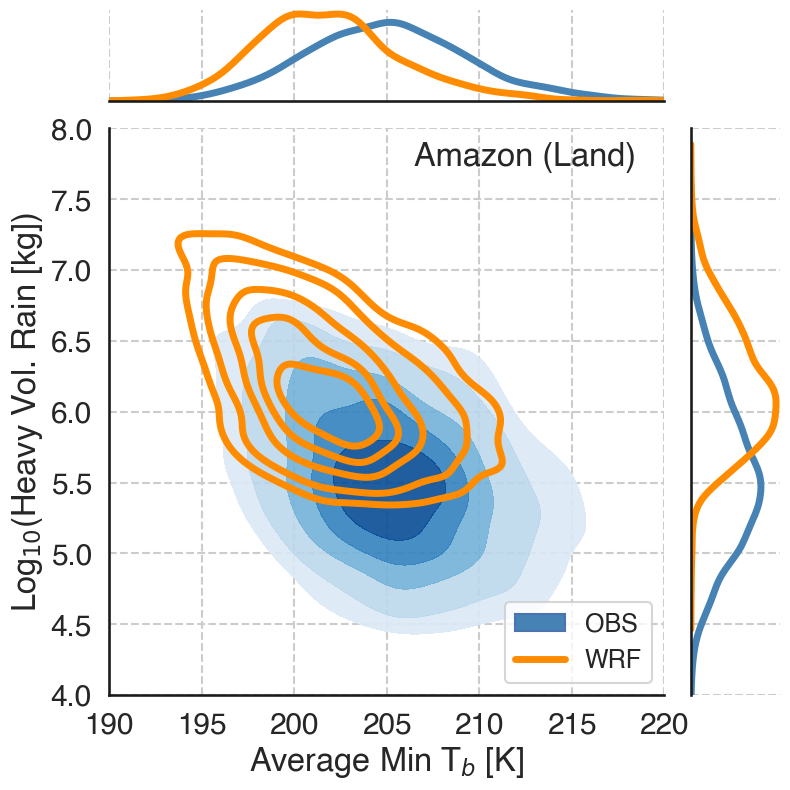

In [65]:
x_obs, y_obs = ds_nms_l_obs.corecold_mintb.mean(dim='times').data, np.log10(ds_nms_l_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2)
x_m1, y_m1 = ds_nms_l_m1.corecold_mintb.mean(dim='times').data, np.log10(ds_nms_l_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2)
xlim = (190,220)
ylim = (4.,8)
xlabel = 'Average Min T$_b$ [K]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
figname = f'{figdir}JointDist_MinTb_HeavyVolrain_{region}_land_imerg_wrf.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

/tmp/ipykernel_2160122/2883991959.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


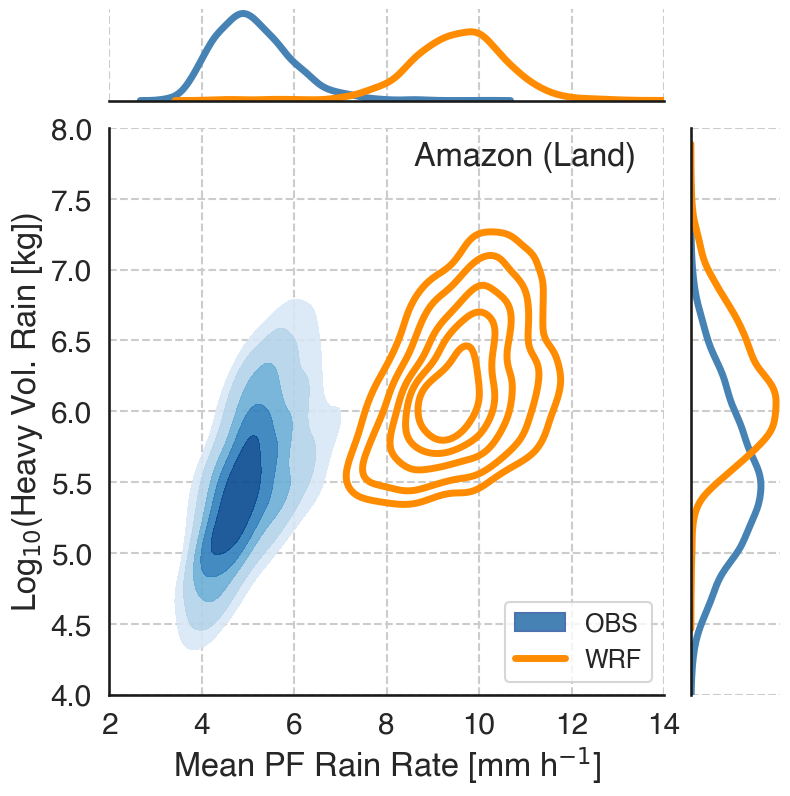

In [66]:
# Largest PF mean rain rate vs. Heavy Rain Volume
x_obs, y_obs = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, np.log10(ds_nms_l_obs.total_heavyrain.sum(dim='times') * pixel_radius_obs**2)
x_m1, y_m1 = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, np.log10(ds_nms_l_m1.total_heavyrain.sum(dim='times') * pixel_radius_m1**2)
xlim = (2,14)
ylim = (4,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
figname = f'{figdir}JointDist_PFrainrate_HeavyVolrain_{region}_land_imerg_wrf.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

/tmp/ipykernel_2160122/2883991959.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap('Blues'))


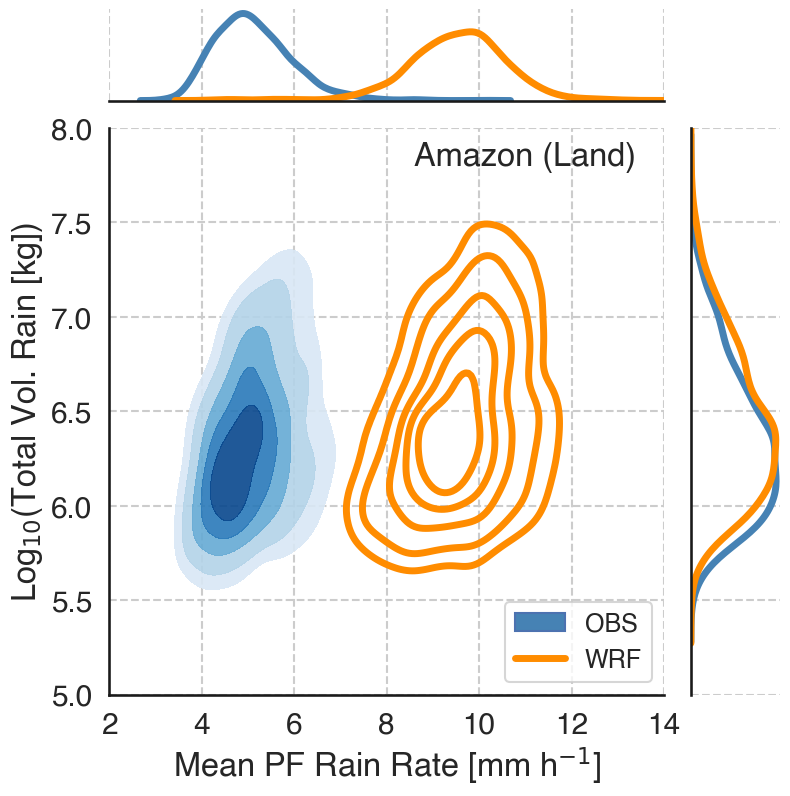

In [67]:
# Largest PF mean rain rate vs. Total Rain Volume
x_obs, y_obs = ds_nms_l_obs.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, np.log10(ds_nms_l_obs.total_rain.sum(dim='times') * pixel_radius_obs**2)
x_m1, y_m1 = ds_nms_l_m1.pf_rainrate.isel(nmaxpf=0).mean(dim='times').data, np.log10(ds_nms_l_m1.total_rain.sum(dim='times') * pixel_radius_m1**2)
xlim = (2,14)
ylim = (5,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
figname = f'{figdir}JointDist_PFrainrate_TotalVolrain_{region}_land_imerg_wrf.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)

In [68]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'